# Synthetic Circular data with gain simulated (dynamic place fields) for hippocampal dataset

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cebra
sys.path.append("/Users/devenshidfar/Desktop/Masters/NRSC_510B/cebra_control_recal")
from cebra_utils import fit_spud_to_cebra


# Set random seed for reproducibility
np.random.seed(42)

## Set synthetic parameters and simulate gain change, also plot the neural activity over time

time: [0 1 2 3 4 5 6 7 8 9]
positions: 1000
gain: [1.         1.0015708  1.00314159 1.00471239 1.00628319 1.00785398
 1.00942478 1.01099557 1.01256637 1.01413717]


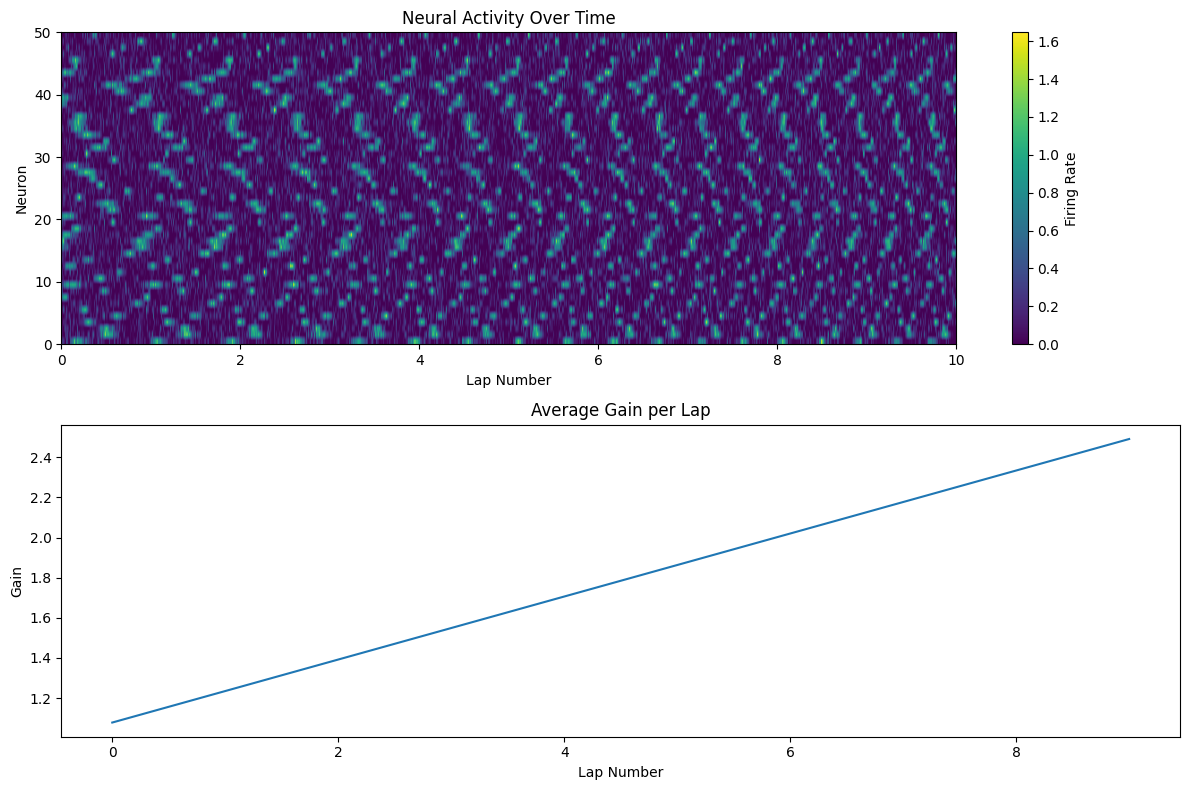

Shape of neural data: (1000, 50)
Mean firing rate: 0.184
Max firing rate: 1.647
Min gain: 1.000
Max gain: 2.569


In [2]:


# Parameters
n_neurons = 50
n_laps = 10
n_positions_per_lap = 100
track_length = 2 * np.pi  # Full circle in radians
total_positions = n_laps * n_positions_per_lap
noise_level = 0.2

#gain params
base_gain = 1.0
gain_change_rate = 0.25

# Create position array
positions = np.linspace(0, n_laps * track_length, total_positions)


# Create time array (assuming constant speed, should change later since not entirely realistic)
time = np.arange(total_positions)
print(f"time: {time[:10]}")
print(f"positions: {total_positions}")

# Function to create place fields
def create_place_fields(n_neurons, track_length):
    centers = np.random.uniform(0, track_length, n_neurons)
    widths = np.random.uniform(0.5, 0.1, n_neurons)
    return centers, widths

# Function to calculate neural activity
def calculate_activity(position, centers, widths):
    distances = np.minimum(np.abs(position - centers), track_length - np.abs(position - centers))
    return np.exp(-((distances) ** 2) / (2 * widths ** 2))

# Create initial place fields
centers, widths = create_place_fields(n_neurons, track_length)

# Initialize neural data array
neural_data = np.zeros((total_positions, n_neurons))

# Simulate changing gain over time (just gradual linear increase since that's the best model related to the JHU dome data)
gain = base_gain + gain_change_rate * 2 * np.pi * time / total_positions
print(f"gain: {gain[:10]}")

hippocampal_position = np.zeros(len(positions))
for i in range (1,len(positions)):
    delta_pos = positions[i] - positions[i-1] #it's the same delta pos regardless but this is a robustness line in case I decide to change the setup
    hippocampal_position[i] = hippocampal_position[i-1] + delta_pos*gain[i]

# for i in range(1,len(hippocampal_position)):
#     print(hippocampal_position[i]-hippocampal_position[i-1])

# Generate neural activity
for i, pos in enumerate(hippocampal_position):
    neural_data[i] = calculate_activity(pos % track_length, centers, widths)

# Add noise
neural_data += np.random.normal(0, noise_level, neural_data.shape)
neural_data = np.maximum(neural_data, 0)  # Ensure non-negative firing rates

# Plotting
plt.figure(figsize=(12, 8))

# Plot neural activity
plt.subplot(211)
plt.imshow(neural_data.T, aspect='auto', cmap='viridis', 
           extent=[0, n_laps, 0, n_neurons])
plt.colorbar(label='Firing Rate')
plt.title('Neural Activity Over Time')
plt.xlabel('Lap Number')
plt.ylabel('Neuron')

# Plot gain over time
plt.subplot(212)
plt.plot(np.arange(n_laps), gain.reshape(-1, n_positions_per_lap).mean(axis=1))
plt.title('Average Gain per Lap')
plt.xlabel('Lap Number')
plt.ylabel('Gain')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Shape of neural data: {neural_data.shape}")
print(f"Mean firing rate: {neural_data.mean():.3f}")
print(f"Max firing rate: {neural_data.max():.3f}")
print(f"Min gain: {gain.min():.3f}")
print(f"Max gain: {gain.max():.3f}")

## Create 2D model and display the embeddings

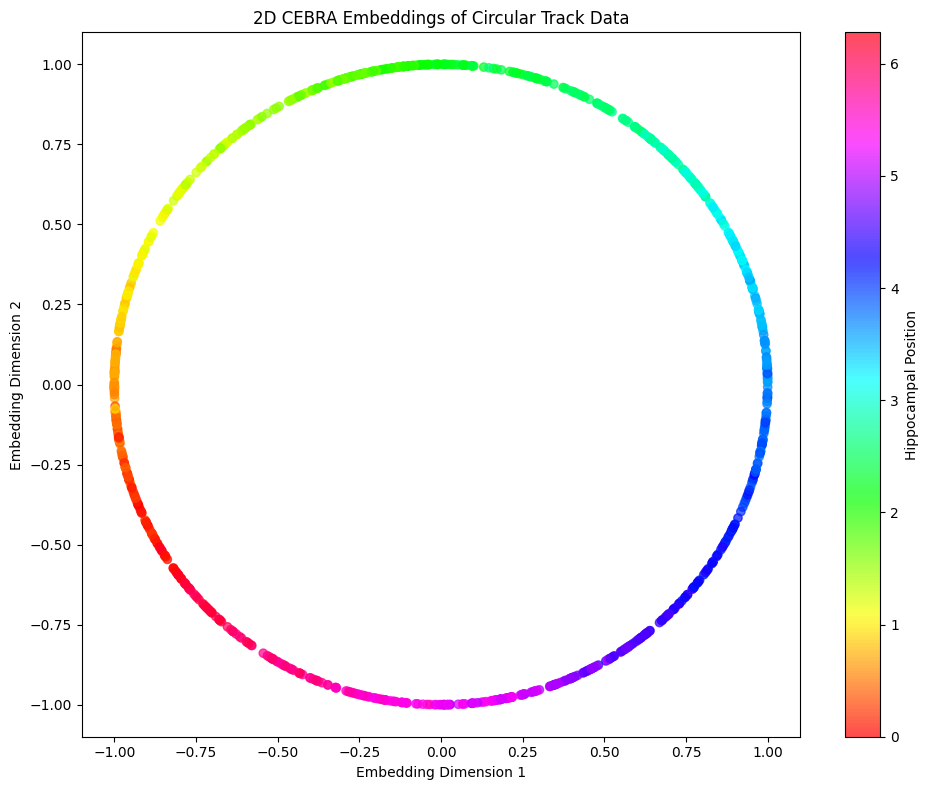

Embedding shape: (1000, 2)
Min values: [-0.99999899 -0.9999994 ]
Max values: [0.9999795  0.99998677]


In [3]:
# Create and fit the CEBRA model
model_2d = cebra.CEBRA(output_dimension=2, batch_size=512, learning_rate=3e-4, max_iterations=1000)
model_2d.fit(neural_data)

# Transform the data to get the embeddings_2d
embeddings_2d = model_2d.transform(neural_data)

# Create the plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], 
                      embeddings_2d[:, 1], 
                      c=hippocampal_position % (2*np.pi), 
                      cmap='hsv',
                      alpha=0.7)

plt.colorbar(scatter, label='Hippocampal Position')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('2D CEBRA Embeddings of Circular Track Data')

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Embedding shape: {embeddings_2d.shape}")
print(f"Min values: {embeddings_2d.min(axis=0)}")
print(f"Max values: {embeddings_2d.max(axis=0)}")

## Now, we apply CEBRA in 3 dimensions and plot below

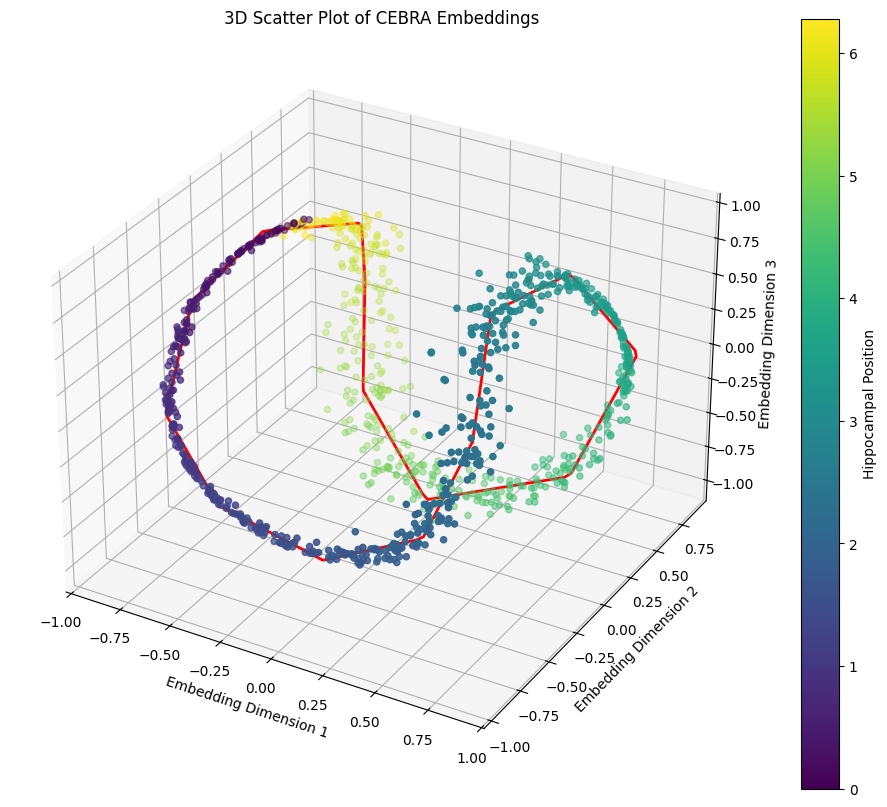

In [4]:
# Create and fit the CEBRA model
model_3d = cebra.CEBRA(output_dimension=3, batch_size=512, learning_rate=3e-4, max_iterations=1000)
model_3d.fit(neural_data)

# Transform the data to get the embeddings_2d
embeddings_3d = model_3d.transform(neural_data)
principal_curve, curve_params = fit_spud_to_cebra(embeddings_3d)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embeddings_3d[:, 0], 
                     embeddings_3d[:, 1], 
                     embeddings_3d[:, 2], 
                     c=hippocampal_position % (2*np.pi), 
                     cmap='viridis')

ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')
ax.set_zlabel('Embedding Dimension 3')
ax.set_title('3D Scatter Plot of CEBRA Embeddings')
ax.plot(principal_curve[:, 0], principal_curve[:, 1], principal_curve[:, 2], color='red', linewidth=2)

cbar = fig.colorbar(scatter, ax=ax, label='Hippocampal Position')

plt.show()


# Testing out decoding behavioural variables (taken directly from cebra demos)

In [5]:
# import sklearn.metrics

# #NOT DONE

# cebra_decode_model = cebra(model_architecture='offset10-model',
#                         batch_size=512,
#                         learning_rate=3e-4,
#                         temperature=1,
#                         output_dimension=output_dimension,
#                         max_iterations=max_iterations,
#                         distance='cosine',
#                         conditional='time_delta',
#                         device='cuda_if_available',
#                         verbose=True,
#                         time_offsets=10)

# def split_data(data,pos, test_ratio):

#     split_idx = int(len(data)* (1-test_ratio))
#     neural_train = neural_data[:split_idx]
#     neural_test = neural_data[split_idx:]
#     label_train = pos[:split_idx]
#     label_test = pos[split_idx:]

#     return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

# neural_train, neural_test, label_train, label_test = split_data(neural_data, 0.2)


# pos_decoder = cebra.KNNDecoder(n_neighbors=36, metric="cosine")

# pos_decoder.fit(embeddings_3d)

# pos_pred = pos_decoder.predict(embedding_test)